# Fitting emission lines in prospector models to s1723, s2340

Michael set me the 'easy' task of fitting emission lines (fluxes and equivalent widths) in a synthetic spectrum
resulting from Gourav's Prospector models.  I first tried using astropy's specutils to do this, and failed utterly
 (see https://github.com/janerigby/NB/blob/master/spectutils_testdrive.ipynb).  I then resorted to using my own tools
(from https://github.com/janerigby/jrr).
Here's what the code below does:
- Find all the emission lines.
- fit the continuum, with the emission lines masked
- subtract the continuum
- use Astropy's compound modeling feature to fit all the lines with Gaussians at once.
 I did the fitting in the observed frame, with flambda (cgs) and wavelength (Angstroms), so that units of flux  measurements are cgs.
I ended up discovering some instabilities with the astropy fitting routines. 

In [37]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from re import sub
import jrr
from astropy import units as u
from astropy.modeling import models, fitting
%matplotlib inline

In [38]:
def sum_of_gaussian(aa, bb, cc) :
    return( aa * cc * np.sqrt(2.0 * np.pi))

def grab_Gouravs_file(filename, zz) :
    # Gourav printed out the SED horizontally (all waves, then all fnus), and weird units
    temp  = pandas.read_csv(filename, delim_whitespace=True, comment='#')
    df = temp.transpose().astype('float64')
    df.reset_index(inplace=True)
    df.columns=['wave', 'fnu_maggies']
    df['fnu'] = df['fnu_maggies']*3631. * 1E-23 # convert from maggies to Janskies to cgs
    df.drop(columns='fnu_maggies', inplace=True)
    df['fnu_u'] = df['fnu'] * 0
    df2 = df.astype('float64').copy(deep=True)
    # Units are now wavelength in Angstroms and fnu in cgs
    jrr.spec.fnu2flam_df(df2)  # convert to flambda     
    jrr.spec.convert2restframe_df(df2, zz, units='fnu', colwave='wave', colf='fnu', colf_u='fnu_u')
    jrr.spec.convert2restframe_df(df2, zz, units='flam', colwave='wave', colf='flam', colf_u='flam_u')
    return(df2)

def unpack_gaussians_from_astropy_2pandas(bestfit, scaleby, zz) :
    # Converts from the astropy fitting output to a pandas dataframe.  assumes input is a compound model of a bunch of gaussians
    theflux   = []
    theamp    = []
    themean   = []
    thestddev = []
    for component in gg_fit:
        flux = sum_of_gaussian( component.amplitude.value *scaleby, component.mean.value, component.stddev.value)
        theflux.append(flux)
        theamp.append(component.amplitude.value)
        themean.append(component.mean.value)
        thestddev.append(component.stddev.value)    
    results = pandas.DataFrame.from_records(np.transpose((theamp, themean, thestddev, theflux)), columns=('amp', 'linecen', 'stddev', 'flux'))
    results['linecen_r'] = results['linecen'] / (1+zz)
    return(results)

def calc_EWs_for_fluxes(fitresults, sp, zz, contwin=10.) :
    #inputs are:
    # fitresults, a data frame containing the results of the Gaussian fitting
    # spectrum, the spectrum that was fit
    # contwin, the window +- the line from which to average the continuum.  in Angstroms.
    localcont = []
    for index, row in fitresults.iterrows() :
        localcont.append(sp.loc[sp['wave'].between(row.linecen - contwin, row.linecen + contwin)]['flam_autocont'].median())
    fitresults['localcont'] = localcont
    fitresults['EW'] = fitresults['flux'] / fitresults['localcont']
    fitresults['EW_r'] =     fitresults['EW']  / (1+zz)
    return(0) # acts on fitresult

In [39]:
datadir = 'Example_data/' # NB/Example_data/
outdir  = '/Users/jrrigby1/Dropbox/Grism_S1723/Gourav_fits/'
infiles = ('1723_bestfit_nov2020.txt',  '2340_bestfit_nov2020.txt')
zzs = {'1723_bestfit_nov2020.txt' : 1.3293  ,  "2340_bestfit_nov2020.txt" : 1.42151}  # Dict of redshifts
pp = PdfPages(outdir + 'fitlines.pdf')
bestfits = {}  # Make some dictionaries to store stuff
spectra = {}
results = {}

In [40]:
for infile in infiles :
    zz = zzs[infile]
    spectra[infile] = grab_Gouravs_file(datadir + infile, zz)

About to fit emission lines to 1723_bestfit_nov2020.txt at z= 1.3293
Found this many peaks:  40
Done fitting emission lines to  1723_bestfit_nov2020.txt at z= 1.3293
About to fit emission lines to 2340_bestfit_nov2020.txt at z= 1.42151
Found this many peaks:  47
Done fitting emission lines to  2340_bestfit_nov2020.txt at z= 1.42151


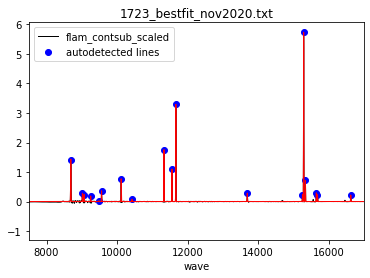

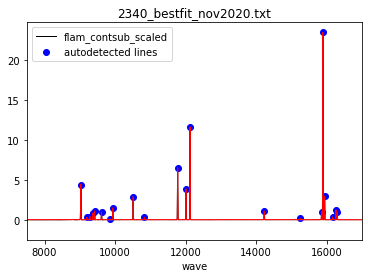

In [41]:
for infile in infiles :
    zz = zzs[infile]
    sp = spectra[infile]
    print("About to fit emission lines to", infile, "at z=", zz)
    (peak_ind, peak_wave, peak_flam) = jrr.spec.find_lines_simple(sp, abs=False, wavcol='wave', fcol='flam', delta=8E-20)  # find the lines
    # Now, make a LL linelist from the auto-detected lines
    LL2 = jrr.sgas.make_a_mage_linelist_from_inputlist(peak_wave/(1+zz), None, zz, vmask=500., ltype='EMISSION', color='red', src='autodetect') 
    sp['contmask'] = False   # a place to mark places that will be flagged as having lines, to not fit continuum there.

    # Fit the continuum. May need to tweak boxcar, and vmask
    jrr.spec.fit_autocont(sp, LL2, zz, colv2mask='vmask', boxcar=71, flag_lines=True, colwave='wave', colf='flam', colmask='contmask', colcont='flam_autocont')
    sp['flam_contsub'] = sp['flam']  - sp['flam_autocont']  
    # Note to Michael:  had to fiddle with vmask and boxcar, to adequately mask all the lines, and to get the continuum smoothness looking "right"

    # Scale flambda and plot
    scaleby = 1E-18  # astropy fitters have trouble with small numbers.  https://github.com/astropy/astropy/issues/6269   Grr.  So, normalize.
    sp['flam_contsub_scaled'] = sp['flam_contsub'] / scaleby
    ax = sp.plot(x='wave', y='flam_contsub_scaled', color='k')
    (sp[sp['peak']]).plot(x='wave', y='flam_contsub_scaled', ax=ax, color='blue', marker='o', ls='', label='autodetected lines')
    plt.xlim(7500,1.7E4)

    # Test out astropy fitting.  Fit one line 
    guess_width = 4.0
    gg_init = models.Gaussian1D(1, peak_wave.iloc[34], guess_width)
    #fitter = fitting.SLSQPLSQFitter()   # This fitter seems super-unstable
    fitter = fitting.LevMarLSQFitter()
    gg_fit_oneline = fitter(gg_init, sp['wave'], sp['flam_contsub_scaled'])

    # Fit Gaussians to each emission line.   Do all lines in peak_wave simultaneously (takes ~1min)
    # Because this is slow, I will do the extra effort of providing as the intiial amplitude guesses the measured peaks from peakdetect.
    # Astropy fitting shouldn't need this, but it does, so let's keep going.
    compound_model = models.Gaussian1D(peak_flam[0]/scaleby,  peak_wave.iloc[0], guess_width)
    plt.plot(sp['wave'], compound_model(sp['wave']), color='pink', label='initial guess')
    for ii in range(1, len(peak_flam)) :
        compound_model += models.Gaussian1D(peak_flam[ii]/scaleby,  peak_wave.iloc[ii], guess_width)
    gg_fit = fitter(compound_model, sp['wave'], sp['flam_contsub_scaled'], maxiter=5000, acc=1E-10)
    bestfits[infile] = gg_fit
    plt.plot( sp['wave'], gg_fit(sp['wave']), color='red')
    plt.title(infile)
    pp.savefig()
    print("Done fitting emission lines to ", infile, "at z=", zz)
pp.close()

In [45]:
# Gaussians are fit, cool. Now, calculate fluxes & EWs, fix the scaleby scaling, and report it all.
for infile in infiles :
    zz = zzs[infile]
    sp = spectra[infile]
    results[infile] = unpack_gaussians_from_astropy_2pandas(bestfits[infile], scaleby, zz)  # covert astropy fit results to a dataframe
    calc_EWs_for_fluxes(results[infile], sp, zz, contwin=50.) 
    outfile = sub('.txt', '_measuredfluxes.csv', infile)
    results[infile].to_csv(outdir + outfile)
    headertext = "# Fits to Gourav synthethic spectrum " + infile + "Units of wave are Angstroms, units of flux are erg/s/cm^2\n"
    headertext +="# Units of amplitudes are flambda, scaled by a factor of " + str(scaleby) + '\n'
    headertext +="# Units of EW are Angstroms, observed frame\n"
    jrr.util.put_header_on_file(outdir + outfile, headertext, outdir + outfile)
    print("Detected emission lines and fit Gaussians, results in", outfile)

Detected emission lines and fit Gaussians, results in 1723_bestfit_nov2020_measuredfluxes.csv
Detected emission lines and fit Gaussians, results in 2340_bestfit_nov2020_measuredfluxes.csv


In [46]:
results[infiles[0]].head()  # For S1723

,amp,linecen,stddev,flux,linecen_r,localcont,EW,EW_r
0,1.147824,2271.793306,2.749097e+01,7.909617e-17,975.311598,1.185919e-18,6.669608e+01,2.863353e+01
1,2.180718,2339.714005,2.169540e+00,1.185925e-17,1004.470873,1.267843e-18,9.353873e+00,4.015744e+00
2,2.078620,2385.189352,1.175494e-38,6.124711e-56,1023.994055,1.323334e-18,4.628242e-38,1.986967e-38
3,1.162852,2442.533774,1.337025e+01,3.897211e-17,1048.612791,1.393243e-18,2.797224e+01,1.200886e+01
4,0.989682,2563.960175,3.947594e+01,9.793049e-17,1100.742787,1.532412e-18,6.390612e+01,2.743576e+01


In [47]:
results[infiles[1]].head() # For S2340

,amp,linecen,stddev,flux,linecen_r,localcont,EW,EW_r
0,1.147824,2271.793306,2.749097e+01,7.909617e-17,938.172176,1.458674e-18,5.422469e+01,2.239293e+01
1,2.180718,2339.714005,2.169540e+00,1.185925e-17,966.221079,1.565417e-18,7.575773e+00,3.128533e+00
2,2.078620,2385.189352,1.175494e-38,6.124711e-56,985.000827,1.615735e-18,3.790664e-38,1.565414e-38
3,1.162852,2442.533774,1.337025e+01,3.897211e-17,1008.682093,1.700088e-18,2.292359e+01,9.466650e+00
4,0.989682,2563.960175,3.947594e+01,9.793049e-17,1058.827003,1.870692e-18,5.234988e+01,2.161869e+01


OK, I'm done here.  To recap, I've measured all the emission lines, and made output tables with the line fluxes (in cgs units), observed-frame equivalent widths (in A), and rest-frame EWs (in A).